In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns

import jax
import numpy as np
import pandas as pd
import scipy.stats as stats
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import RectifiedLogistic
from core import DATA_PATH, MAT_PATH, BUILD_DIR

logger = logging.getLogger(__name__)
plt.rcParams['svg.fonttype'] = 'none'
setup_logging(dir=BUILD_DIR, fname="")


2024-04-15 10:08:12,608 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/.log


In [2]:
dest = os.path.join(BUILD_DIR, "rectified_logistic", "inference.pkl")
with open(dest, "rb") as f:
    model, mcmc, posterior_samples, posterior_predictive = pickle.load(f)


2024-04-15 10:08:12,760 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-04-15 10:08:12,761 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-04-15 10:08:12,767 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
df = pd.read_csv(DATA_PATH)
mat = np.load(MAT_PATH)
df, encoder_dict = model.load(df=df)
prediction_df = pd.read_csv(os.path.join(model.build_dir, "prediction_df.csv"))


2024-04-15 10:08:13,727 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/rectified_logistic
2024-04-15 10:08:13,730 - hbmep.dataset.core - INFO - Processing data ...
2024-04-15 10:08:13,732 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [4]:
posterior_samples["s50"].shape

(4000, 1, 2)

In [5]:
obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)
obs_map = obs.mean(axis=0)
logger.info(f"obs: {obs.shape}")
logger.info(f"obs_hpdi: {obs_hpdi.shape}")
logger.info(f"obs_map: {obs_map.shape}")

a = posterior_samples[site.a]
a_map = a.mean(axis=0)
logger.info(f"a: {a.shape}")
logger.info(f"a_map: {a_map.shape}")

H = posterior_samples[site.H]
H_map = H.mean(axis=0)
logger.info(f"H: {H.shape}")
logger.info(f"H_map: {H_map.shape}")


2024-04-15 10:08:15,633 - __main__ - INFO - obs: (4000, 5000, 2)
2024-04-15 10:08:15,633 - __main__ - INFO - obs_hpdi: (2, 5000, 2)
2024-04-15 10:08:15,634 - __main__ - INFO - obs_map: (5000, 2)
2024-04-15 10:08:15,634 - __main__ - INFO - a: (4000, 1, 2)
2024-04-15 10:08:15,634 - __main__ - INFO - a_map: (1, 2)
2024-04-15 10:08:15,635 - __main__ - INFO - H: (4000, 1, 2)
2024-04-15 10:08:15,635 - __main__ - INFO - H_map: (1, 2)


In [6]:
sites = [site.a, site.b, site.L, site.ell, site.H]
params_mode = [stats.mode(posterior_samples[u], axis=0) for u in sites]
params_mode = [param.mode for param in params_mode]
params_mode = [param[0] for param in params_mode]
params = [np.mean(posterior_samples[u], axis=0) for u in sites]
params = [param[0] for param in params]


In [7]:
mep_window = [-0.01, 0.025]
mep_size_window = [0.0015, 0.01]
time = np.linspace(*mep_window, mat.shape[1])

# MEP_TIME_CONST = 1000
# MEP_CONST = [200, 100]
COLORS = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]


In [8]:
intensity, features = model._get_regressors(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (1, model.n_response))
feature0 = features[..., 0].reshape(-1,)

a, b, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

params = [a, b, L, ell, H]
params = [u[:, feature0] for u in params]

fn_out = F.rectified_logistic(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = F.prime(F.rectified_logistic, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out = np.array(fn_prime_out)
fn_prime_out.shape


(4000, 5000, 2)

In [9]:
MEP_TIME_CONST = 1000
TIME_CONST = 1000

tick_label_size = 12
axis_label_size = 12


In [10]:
s50 = posterior_samples["s50"]
s50.shape


(4000, 1, 2)

In [11]:
src = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/nelder_mead/minimize_result.pkl"
with open(src, "rb") as f:
    nm_params, = pickle.load(f)


2024-04-15 10:21:29,809 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/rectified_logistic/introduction.png


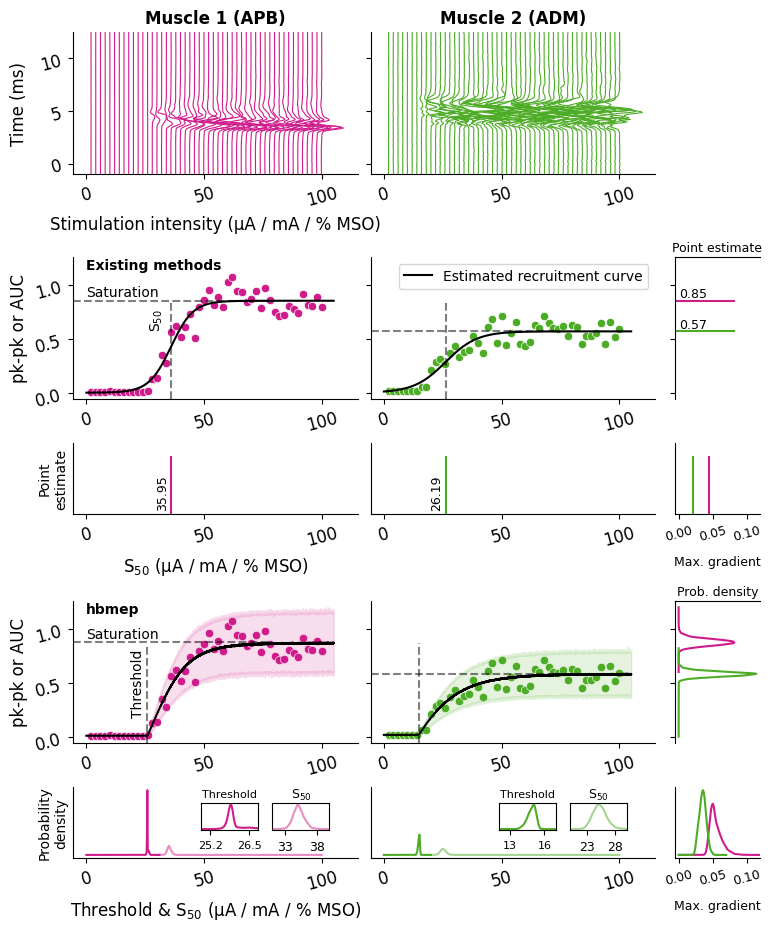

In [23]:
MEP_CONST = [250, 50]

nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7.6, 9.2), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    # MEP plot
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, (muscle_ind + 1) % 2] / MEP_CONST[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
    ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)

    # Logistic4
    # Recruitment curve lineplot
    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]

    sns.lineplot(
        x=x_pred,
        y=F.logistic4(
            x_pred,
            nm_params[site.a][0][muscle_ind],
            nm_params[site.b][0][muscle_ind],
            nm_params[site.L][0][muscle_ind],
            nm_params[site.H][0][muscle_ind]
        ),
        ax=ax,
        color="k",
        label="Estimated recruitment curve"
    )

    # Recruitment curve scatterplot
    sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

    if ax == axes[1, 0]:
        ax.axvline(x=nm_params[site.a][0][muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.68)
        ax.text((nm_params[site.a][0][muscle_ind] - 2.5), nm_params[site.H][0][muscle_ind] - .07, "S$_{50}$", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=nm_params[site.H][0][muscle_ind], color="black", xmax=.7, alpha=.5, linestyle="--")
        ax.text(0, nm_params[site.H][0][muscle_ind] + .01, "Saturation", va="bottom", ha="left")

    if ax == axes[1, 1]:
        ax.axvline(x=nm_params[site.a][0][muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.7)

    if ax == axes[1, 1]:
        ax.axhline(y=nm_params[site.H][0][muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

    # Threshold Point Estimate
    ax = axes[2, muscle_ind]
    ax.axvline(nm_params[site.a][0][muscle_ind], color=COLORS[muscle_ind], ymax=.8)

    # Saturation Point Estimate
    ax = axes[1, 2]
    ax.axhline(nm_params[site.H][0][muscle_ind], color=COLORS[muscle_ind], xmax=.7)

    # Max Gradient Point Estimate
    ax = axes[2, 2]
    ax.axvline(
        jax.grad(F.logistic4, argnums=0)(
            nm_params[site.a][0][muscle_ind],
            nm_params[site.a][0][muscle_ind],
            nm_params[site.b][0][muscle_ind],
            nm_params[site.L][0][muscle_ind],
            nm_params[site.H][0][muscle_ind]
        ),
        color=COLORS[muscle_ind],
        ymax=.8
    )

    # Rectified Logistic
    # Recruitment curve lineplot
    ax = axes[3, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]

    sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color="k", label="Recruitment Curve")

    # Recruitment curve scatterplot
    sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

    # Recruitment curve HPDI
    ax.fill_between(
        x_pred,
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=COLORS[muscle_ind],
        alpha=.15
    )

    if ax == axes[3, 0]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.68)
        ax.text((a_map[0, muscle_ind] - 1), obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[3, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.7, alpha=.5, linestyle="--")
        ax.text(0, obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="left")

    if ax == axes[3, 1]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.7)

    if ax == axes[3, 1]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

    # # Debuging
    # axes[3, 1].axhline(obs_map.max(axis=0)[muscle_ind])
    # axes[3, 2].axhline(obs_map.max(axis=0)[muscle_ind])

    # Threshold KDE
    match muscle_ind:
        case 0: bounds = [0, 31]
        case 1: bounds = [0, 20]
    ax = axes[4, muscle_ind]
    samples = a[:, 0, muscle_ind]
    samples = samples
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    x_grid = x_grid[(x_grid >= bounds[0]) & (x_grid <= bounds[1])]
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])
    ins = ax.inset_axes([0.45,0.39,0.2,0.38])
    ins.plot(x_grid, density, color=COLORS[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_title("Threshold", size=axis_label_size - 4, pad=4)

    if muscle_ind == 0:
        ticks = [25.2, 26.5]
        bounds = [24.9, 26.8]

    if muscle_ind == 1:
        ticks = [13, 16]
        bounds = [12, 17]

    ins.set_xticks(ticks)
    ins.set_xlim(left=bounds[0], right=bounds[1])

    ins.tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=True,
        right=False,
        top=False,
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=0
    )

    # S50 KDE
    match muscle_ind:
        case 0: bounds = [30, 100]
        case 1: bounds = [18, 100]
    ax = axes[4, muscle_ind]
    samples = s50[:, 0, muscle_ind]
    samples = samples
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    x_grid = x_grid[(x_grid >= bounds[0]) & (x_grid <= bounds[1])]
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind], alpha=.5)
    ins = ax.inset_axes([0.7,0.39,0.2,0.38])
    ins.plot(x_grid, density, color=COLORS[muscle_ind], alpha=.5)
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_title("S$_{50}$", size=axis_label_size - 3, pad=4)

    if muscle_ind == 0:
        ticks = [33, 38]
        bounds = [31, 40]

    if muscle_ind == 1:
        ticks = [23, 28]
        bounds = [20, 30]

    ins.set_xticks(ticks)
    ins.set_xlim(left=bounds[0], right=bounds[1])

    ins.tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=True,
        right=False,
        top=False,
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=9,
        labelrotation=0
    )

    # Saturation KDE
    x_grid = np.linspace(0, 1.2, 100)
    ax = axes[3, 2]
    if muscle_ind == 0:
        samples = H[:, 0, muscle_ind] + .018
        x_grid = np.linspace(.6, 1.2, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, muscle_ind] + .018
        x_grid = np.linspace(0, .82, 5000)

    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=COLORS[muscle_ind])

    # Max Gradient KDE
    ax = axes[4, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    samples = samples
    kde = stats.gaussian_kde(samples)
    if muscle_ind == 0: x_grid = np.linspace(0, .12, 5000)
    if muscle_ind == 1: x_grid = np.linspace(0, .07, 5000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

# Share y-axis
axes[0, 1].sharey(axes[0, 0])
subset = [(1, 0), (1, 1), (1, 2), (3, 1), (3, 2)]
for i, j in subset: axes[i, j].sharey(axes[3, 0])
axes[4, 1].sharey(axes[4, 0])

# Share x-axis
for i in range(nrows):
    for j in range(ncols - 1):
        axes[i, j].sharex(axes[0, 0])
axes[2, 2].sharex(axes[4,2])

# Legend
subset = [(1, 0), (3, 0), (3, 1)]
for i, j in subset:
    ax = axes[i, j]
    if ax.get_legend(): ax.get_legend().remove()

for i in range(nrows):
    for j in range(ncols - 1):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)

        left = True
        labelleft = False

        if j == 0:
            labelleft = True

        if i in (2, 4):
            left=False
            labelleft = False

        ax.tick_params(
            axis='both',
            which='both',
            left=left,
            bottom=True,
            right=False,
            top=False,
            labelleft=labelleft,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15,
            labelsize=tick_label_size
        )

ax = axes[0, 2]
for side in ['left', 'top', 'right', 'bottom']:
    ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=False,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=False,
        labelright=False,
        labeltop=False,
    )

for i in range(1, nrows):
    ax = axes[i, 2]
    sides = ['right', 'top']
    left = False
    labelleft = False
    bottom = True
    labelbottom = True

    if i in (1, 3):
        sides = ['right', 'bottom']
        left = True
        bottom = False
        labelbottom = False

    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=left,
        bottom=bottom,
        right=False,
        top=False,
        labelleft=labelleft,
        labelbottom=labelbottom,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=tick_label_size
    )

# x-axis ticks
ax = axes[0, 0]
ax.set_xticks([0, 50, 100])
ax.set_yticks([0., 5, 10])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

ax = axes[1, 0]
ax.set_yticks([0., .5, 1])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

ax = axes[4, 2]
ax.set_xticks([0., .05, .1])
ax.set_xlim(right=.12)
ax.tick_params(axis="x", labelsize=tick_label_size - 3)
ax = axes[2, 2]
ax.tick_params(axis="x", labelsize=tick_label_size - 3)

# Axes labels
axes[0, 0].set_xlabel("Stimulation intensity (µA / mA / % MSO)", size=axis_label_size)
axes[2, 0].set_xlabel("S$_{50}$ (µA / mA / % MSO)", size=axis_label_size)
axes[4, 0].set_xlabel("Threshold & S$_{50}$ (µA / mA / % MSO)", size=axis_label_size)
ax = axes[1, 2]
ax.set_xlabel("Point estimate", size=axis_label_size - 3)
ax.xaxis.set_label_position('top')
ax = axes[3, 2]
ax.set_xlabel("Prob. density", size=axis_label_size - 3)
ax.xaxis.set_label_position('top')
axes[2, 2].set_xlabel("Max. gradient", size=axis_label_size - 3)
axes[4, 2].set_xlabel("Max. gradient", size=axis_label_size - 3)

axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("pk-pk or AUC", size=axis_label_size)
axes[3, 0].set_ylabel("pk-pk or AUC", size=axis_label_size)
axes[2, 0].set_ylabel("Point\nestimate", size=axis_label_size - 2)
axes[4, 0].set_ylabel("Probability\ndensity", size=axis_label_size - 2)

axes[0, 0].set_title("Muscle 1 (APB)", fontweight="bold")
axes[0, 1].set_title("Muscle 2 (ADM)", fontweight="bold")

for muscle_ind in range(2):
    ax = axes[2, muscle_ind]
    point_estimate = nm_params[site.a][0][muscle_ind]
    ax.text(point_estimate - 1, 0.05, f"{point_estimate:.2f}", va="bottom", ha="right", rotation=90, fontsize=9)
    ax = axes[1, 2]
    point_estimate = nm_params[site.H][0][muscle_ind]
    ax.text(0.05, point_estimate, f"{point_estimate:.2f}", va="bottom", ha="left", fontsize=9)
    # ax = axes[2, 2]
    # point_estimate = jax.grad(F.logistic4, argnums=0)(
    #     nm_params[site.a][0][muscle_ind],
    #     nm_params[site.a][0][muscle_ind],
    #     nm_params[site.b][0][muscle_ind],
    #     nm_params[site.L][0][muscle_ind],
    #     nm_params[site.H][0][muscle_ind]
    # )
    # ax.text(point_estimate-.002, 0.05, f"{point_estimate:.2f}", va="bottom", ha="right", rotation=90, fontsize=8)

ax = axes[1, 0]
ax.text(0, 1.12, "Existing methods", fontweight="semibold", va="bottom", ha="left")

ax = axes[3, 0]
ax.text(0, 1.12, "hbmep", fontweight="semibold", va="bottom", ha="left")

fig.align_xlabels()
fig.align_ylabels([axes[0, 0], axes[1, 0], axes[3, 0]])
fig.align_ylabels([axes[2, 0], axes[4, 0]])

dest = os.path.join(model.build_dir, "introduction.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "introduction.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")


In [ ]:
# MEP_CONST = [250, 50]

# nrows, ncols = 3, 3
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 6.5), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

# for muscle_ind in [0, 1]:
#     # MEP plot
#     ax = axes[0, muscle_ind]
#     for k in range(mat.shape[0]):
#         x = mat[k, :, (muscle_ind + 1) % 2] / MEP_CONST[muscle_ind]
#         x += df[model.intensity].values[k]
#         ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
#     ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
#     ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)

#     # Recruitment curve lineplot
#     ax = axes[1, muscle_ind]
#     x_pred = prediction_df[model.intensity].values
#     x = df[model.intensity]

#     sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")

#     # Recruitment curve scatterplot
#     sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

#     # Recruitment curve HPDI
#     ax.fill_between(
#         x_pred,
#         obs_hpdi[0, ..., muscle_ind],
#         obs_hpdi[1, ..., muscle_ind],
#         color=COLORS[muscle_ind],
#         alpha=.15
#     )

#     if ax == axes[1, 0]:
#         ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.68)
#         # ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymin=.83, ymax=1)
#         ax.text((a_map[0, muscle_ind] - 1), obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right")

#     if ax == axes[1, 0]:
#         ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.7, alpha=.5, linestyle="--")
#         ax.text((a_map[0, muscle_ind] - 5), obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="center")

#     if ax == axes[1, 1]:
#         ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.8)

#     if ax == axes[1, 1]:
#         ax.axhline(y=obs_map.max(axis=0)[muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

#     # # Debuging
#     # axes[1, 1].axhline(obs_map.max(axis=0)[muscle_ind])
#     # axes[1, 2].axhline(obs_map.max(axis=0)[muscle_ind])

#     # Threshold KDE
#     ax = axes[2, muscle_ind]
#     samples = a[:, 0, muscle_ind]
#     samples = samples
#     kde = stats.gaussian_kde(samples)
#     x_grid = prediction_df[model.intensity]
#     x_grid = x_grid[x_grid <= 100]
#     density = kde(x_grid)
#     ax.plot(x_grid, density, color=COLORS[muscle_ind])
#     ins = ax.inset_axes([0.6,0.4,0.3,0.5])
#     ins.plot(x_grid, density, color=COLORS[muscle_ind])
#     ins.set_xlabel("")
#     ins.set_ylabel("")

#     if muscle_ind == 0:
#         ticks = [25.5, 26.5]
#         bounds = [25, 27]
#         ins.set_xticks(ticks)
#         ins.set_xlim(left=bounds[0], right=bounds[1])

#     if muscle_ind == 1:
#         ticks = [13, 16]
#         bounds = [12, 17]
#         ins.set_xticks(ticks)
#         ins.set_xlim(left=bounds[0], right=bounds[1])

#     ins.tick_params(
#         axis='both',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         left=False,      # ticks along the bottom edge are off
#         bottom=True,      # ticks along the bottom edge are off
#         right=False,         # ticks along the top edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=True,
#         labelleft=False,
#         labelright=False,
#         labelsize=10,
#         labelrotation=0
#     )

#     # Saturation KDE
#     x_grid = np.linspace(0, 1.2, 100)
#     ax = axes[1, 2]
#     if muscle_ind == 0:
#         samples = H[:, 0, muscle_ind] + .018
#         x_grid = np.linspace(.6, 1.2, 5000)

#     if muscle_ind == 1:
#         samples = H[:, 0, muscle_ind] + .018
#         x_grid = np.linspace(0, .82, 5000)

#     kde = stats.gaussian_kde(samples)
#     density = kde(x_grid)
#     ax.plot(density, x_grid, color=COLORS[muscle_ind])

#     # Max Gradient KDE
#     ax = axes[2, 2]
#     max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
#     samples = max_grad
#     samples = samples * 2
#     kde = stats.gaussian_kde(samples)
#     if muscle_ind == 0: x_grid = np.linspace(.05, .2, 1000)
#     if muscle_ind == 1: x_grid = np.linspace(.01, .14, 1000)
#     density = kde(x_grid)
#     ax.plot(x_grid, density, color=COLORS[muscle_ind])

# for i in range(nrows):
#     for j in range(ncols):
#         ax = axes[i, j]
#         ax.set_xlabel("")
#         ax.set_ylabel("")

# subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
# for i, j in subset:
#     ax = axes[i, j]
#     sides = ['right', 'top']
#     for side in sides:
#         ax.spines[side].set_visible(False)
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=True,
#         bottom=True,
#         right=False,
#         top=False,
#         labelleft=False,
#         labelbottom=True,
#         labelright=False,
#         labeltop=False,
#         labelrotation=15,
#         labelsize=tick_label_size
#     )

# subset = [(2, 0), (2, 1), (2, 2)]
# for i, j in subset:
#     ax = axes[i, j]
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=False,
#         labelleft=False,
#         rotation=15,
#         labelsize=tick_label_size
#     )

# ax = axes[0, 2]
# sides = ['left', 'top', 'right', 'bottom']
# for side in sides:
#     ax.spines[side].set_visible(False)
# ax.tick_params(
#     axis='both',
#     which='both',
#     left=False,
#     bottom=False,
#     right=False,
#     top=False,
#     labelleft=False,
#     labelbottom=False,
#     labelright=False,
#     labeltop=False,
#     rotation=15,
#     labelsize=tick_label_size
# )

# ax = axes[1, 2]
# sides = ['right', 'bottom']
# for side in sides:
#     ax.spines[side].set_visible(False)
# ax.tick_params(
#     axis='both',
#     which='both',
#     left=True,
#     bottom=False,
#     right=False,
#     top=False,
#     labelleft=False,
#     labelbottom=False,
#     labelright=False,
#     labeltop=False,
# )

# ##############
# # Share y-axis
# axes[0, 1].sharey(axes[0, 0])
# axes[1, 1].sharey(axes[1, 0])
# axes[1, 2].sharey(axes[1, 0])
# axes[2, 1].sharey(axes[2, 0])

# # Share x-axis
# axes[0, 1].sharex(axes[0, 0])
# axes[1, 0].sharex(axes[0, 0])
# axes[1, 1].sharex(axes[0, 0])
# axes[2, 0].sharex(axes[0, 0])
# axes[2, 1].sharex(axes[0, 0])

# # x-axis ticks
# ax = axes[0, 0]
# ax.set_xticks([0, 50, 100])
# ax.set_yticks([0. * MEP_TIME_CONST, .005 * MEP_TIME_CONST, .01 * MEP_TIME_CONST])
# ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

# ax = axes[1, 0]
# axes[1, 0].set_yticks([0., .500, 1])
# ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)
# if ax.get_legend(): ax.get_legend().remove()

# ax = axes[1, 1]
# if ax.get_legend(): ax.get_legend().remove()

# ax = axes[2, 2]
# ax.set_xticks([0., .1, .2])
# ax.tick_params(axis="x", labelsize=tick_label_size - 2)
# ax.set_xlabel("Max. Gradient", size=axis_label_size - 2)

# # Axes labels
# axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
# axes[1, 0].set_ylabel("MEP Size (a.u.)", size=axis_label_size)
# axes[0, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
# axes[1, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
# axes[2, 0].set_xlabel("Threshold (µA / mA / % MSO)", size=axis_label_size)
# axes[2, 0].set_ylabel("Probability Density", size=axis_label_size)

# ax = axes[1, 2]
# ax.set_xlabel("Prob. Density", size=axis_label_size - 2)
# ax.xaxis.set_label_position('top')

# axes[0, 0].set_title("Muscle 1 (APB)", fontweight="bold")
# axes[0, 1].set_title("Muscle 2 (ADM)", fontweight="bold")

# ax = axes[0, 0]
# ax.set_xlim(right=105)

# fig.align_xlabels()
# fig.align_ylabels()
# fig.align_labels()

# dest = os.path.join(model.build_dir, "01c_HB.svg")
# fig.savefig(dest, dpi=600)

# dest = os.path.join(model.build_dir, "01c_HB.png")
# fig.savefig(dest, dpi=600)

# logger.info(f"Saved to {dest}")
